In [1]:
%matplotlib inline

In [2]:
import os.path
import pprint

import pandas as pd

from gmprocess.io.asdf.stream_workspace import StreamWorkspace
from gmprocess.io.test_utils import read_data_dir
from gmprocess.io.read import read_data
from gmprocess.core.streamcollection import StreamCollection
from gmprocess.waveform_processing.processing import process_streams
from gmprocess.utils.event import get_event_object
from gmprocess.utils.logging import setup_logger

# Only log errors; this suppresses many warnings that are
# distracting and not important.
setup_logger(level='error')

## Reading Data
We currently have a few different ways of reading in data. Here we use the `read_data_dir` helper function to quickly read streams and event (i.e., origin) information from the testing data in this repository.

In [3]:
datafiles, origin = read_data_dir('geonet', 'us1000778i', '*.V1A')

The read_data below finds the appropriate data reader for the format supplied.

In [4]:
tstreams = []
for dfile in datafiles:
    tstreams += read_data(dfile)

Note that `tstreams` is just a list of StationStream objects:

In [5]:
print(type(tstreams))
print(type(tstreams[0]))

<class 'list'>
<class 'gmprocess.core.stationstream.StationStream'>


## gmprocess Subclasses of Obspy Classes

The `StationStream` class is a subclass of ObsPy's `Stream` class, which is effectively a list of `StationTrace` objects.  The `StationTrace` class is, in turn, a subclass of ObsPy's `Trace` class. The motivation for these subclasses is primarily to enforce certain required metadata in the Trace stats dictionary (that ObsPy would generally store in their `Inventory` object).

We also have a `StreamCollection` class taht is effectively a list of `StationStream` objects, and enforces some rules that are required later for processing, such forcing all `StationTraces` in a `StationStream` be from the same network/station. The basic constructor for the StreamCollection class takes a list of streams:

In [6]:
sc = StreamCollection(tstreams)

The StreamCollection print method gives the number of StationStreams and the number that have passed/failed processing checks. Since we have not done any processing, all StationStreams should pass checks.

In [7]:
print(sc)

3 StationStreams(s) in StreamCollection:
    3 StationStreams(s) passed checks.
    0 StationStreams(s) failed checks.



More detailed information about the StreamCollection is given by the `describe` method:

In [8]:
sc.describe()

3 StationStreams(s) in StreamCollection:
  3 StationTrace(s) in StationStream (passed):
    NZ.HSES.--.HN1 | 2016-11-13T11:02:20.000000Z - 2016-11-13T11:07:47.675000Z | 200.0 Hz, 65536 samples (passed)
    NZ.HSES.--.HN2 | 2016-11-13T11:02:20.000000Z - 2016-11-13T11:07:47.675000Z | 200.0 Hz, 65536 samples (passed)
    NZ.HSES.--.HNZ | 2016-11-13T11:02:20.000000Z - 2016-11-13T11:07:47.675000Z | 200.0 Hz, 65536 samples (passed)
  3 StationTrace(s) in StationStream (passed):
    NZ.WTMC.--.HN1 | 2016-11-13T11:02:19.000001Z - 2016-11-13T11:07:46.675001Z | 200.0 Hz, 65536 samples (passed)
    NZ.WTMC.--.HN2 | 2016-11-13T11:02:19.000001Z - 2016-11-13T11:07:46.675001Z | 200.0 Hz, 65536 samples (passed)
    NZ.WTMC.--.HNZ | 2016-11-13T11:02:19.000001Z - 2016-11-13T11:07:46.675001Z | 200.0 Hz, 65536 samples (passed)
  3 StationTrace(s) in StationStream (passed):
    NZ.THZ.--.HN2 | 2016-11-13T11:02:33.000000Z - 2016-11-13T11:07:28.995000Z | 200.0 Hz, 59200 samples (passed)
    NZ.THZ.--.HN1 | 2

## Processing
Note that processing options can be controlled in a config file that is installed in the user's home directory (`~/.gmprocess/config.yml`) and that event/origin information is required for processing:

In [9]:
pprint.pprint(origin)
sc_processed = process_streams(sc, origin)
print(sc_processed)

{'depth': 15.11,
 'id': 'us1000778i',
 'lat': -42.7373,
 'lon': 173.054,
 'magnitude': 7.8,
 'time': '2016-11-13T11:02:56.340000'}
3 StationStreams(s) in StreamCollection:
    3 StationStreams(s) passed checks.
    0 StationStreams(s) failed checks.



Note that all checks have passed. When a stream does not pass a check, it is not deleted, but marked as failed and subsequent processing is aborted.

Processing steps are recorded according to the SEIS-PROV standard for each StationTrace. We log this information as a list of dictionaries, where each dictionary has keys `prov_id` and `prov_attributes`. This can be retrieved from each traces with the `getAllProvenance` method:

In [10]:
pprint.pprint(sc_processed[0][0].getAllProvenance())

[{'prov_attributes': {'input_units': 'counts', 'output_units': 'cm/s^2'},
  'prov_id': 'remove_response'},
 {'prov_attributes': {'detrending_method': 'linear'}, 'prov_id': 'detrend'},
 {'prov_attributes': {'detrending_method': 'demean'}, 'prov_id': 'detrend'},
 {'prov_attributes': {'new_end_time': UTCDateTime(2016, 11, 13, 11, 5, 44, 175000),
                      'new_start_time': UTCDateTime(2016, 11, 13, 11, 2, 58, 655000)},
  'prov_id': 'cut'},
 {'prov_attributes': {'side': 'both',
                      'taper_width': 0.05,
                      'window_type': 'Hann'},
  'prov_id': 'taper'},
 {'prov_attributes': {'corner_frequency': 0.08,
                      'filter_order': 5,
                      'filter_type': 'Butterworth',
                      'number_of_passes': 2},
  'prov_id': 'highpass_filter'},
 {'prov_attributes': {'corner_frequency': 20.0,
                      'filter_order': 5,
                      'filter_type': 'Butterworth',
                      'number_of_pas

## Workspace
We use the ASDF format as a 'workspace' for saving data and metadata at all stages of processing/analysis.

In [11]:
outfile = os.path.join(os.path.expanduser('~'), 'geonet_test.hdf')
if os.path.isfile(outfile):
    os.remove(outfile)
workspace = StreamWorkspace(outfile)
# create an ObsPy event object from our dictionary
event = get_event_object(origin)

# add the "raw" (GEONET actually pre-converts to gals) data
workspace.addStreams(event, sc, label='rawgeonet')
eventid = origin['id']

workspace.addStreams(event, sc_processed, label='processed')

## Creating and Retrieving Stream Metrics
Computation of metrics requires specifying a list of requested intensity measure types (IMTs) and intensity measure components (IMCs). Not all IMT-IMC combinations are currently supported and in those cases the code returns NaNs. 

For real uses (not just demonstration) it is probably more convenient to specify these values through the config file, which allows for specifying response spectral periods and Fourier amplitude spectra periods as linear or logspaced arrays.

In [12]:
imclist = [
    'greater_of_two_horizontals',
    'channels',
    'rotd50',
    'rotd100'
]
imtlist = [
    'sa1.0',
    'PGA',
    'pgv',
    'fas2.0',
    'arias'
]
workspace.setStreamMetrics(
    eventid, 
    labels=['processed'], 
    imclist=imclist,
    imtlist=imtlist
)
df = workspace.getMetricsTable(
    eventid, 
    labels=['processed']
)

There are a lot of columns here, so we'll show them in sections:

In [13]:
pd.set_option('display.width', 1000)
print('ARIAS:')
print(df['ARIAS'])
print('\nSpectral Acceleration (1 second)')
print(df['SA(1.0)'])
print('\nFourier Amplitude Spectra (2 second)')
print(df['FAS(2.0)'])
print('\nPGA')
print(df['PGA'])
print('\nPGV')
print(df['PGV'])

print('\nStation Information:')
print(df[['STATION', 'NAME', 'LAT', 'LON', 'SOURCE', 'NETID']])

ARIAS:
   GEOMETRIC_MEAN  GREATER_OF_TWO_HORIZONTALS      HN1     HN2      HNZ  ROTD100.0  ROTD50.0
0             NaN                      2.7744   2.2772  2.7744   0.6097     2.7921    2.5212
1             NaN                      0.1384   0.1183  0.1384   0.0567     0.1477    0.1282
2             NaN                     12.6649  12.6649  8.9070  12.8956    13.8093   10.8083

Spectral Acceleration (1 second)
   GEOMETRIC_MEAN  GREATER_OF_TWO_HORIZONTALS       HN1      HN2      HNZ  ROTD100.0  ROTD50.0
0             NaN                     42.0960   42.0960  41.8349  12.7510    47.8483   42.0960
1             NaN                      8.5429    8.5429   8.1002   5.1524     9.7224    8.4973
2             NaN                    134.0321  134.0321  81.5174  28.1952   144.8310  102.8883

Fourier Amplitude Spectra (2 second)
   GEOMETRIC_MEAN  GREATER_OF_TWO_HORIZONTALS  HN1  HN2  HNZ  ROTD100.0  ROTD50.0
0          0.5071                         NaN  NaN  NaN  NaN        NaN       NaN
1    

## Retrieving Streams

In [14]:
raw_hses = workspace.getStreams(
    eventid,
    stations=['hses'],
    labels=['rawgeonet'])[0]
processed_hses = workspace.getStreams(
    eventid,
    stations=['hses'],
    labels=['processed'])[0]

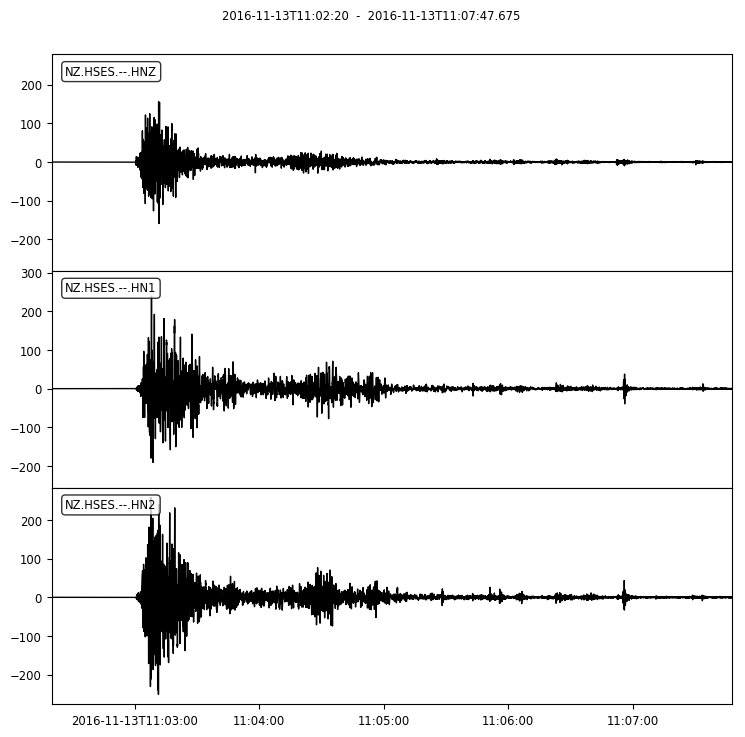

In [15]:
raw_hses.plot()

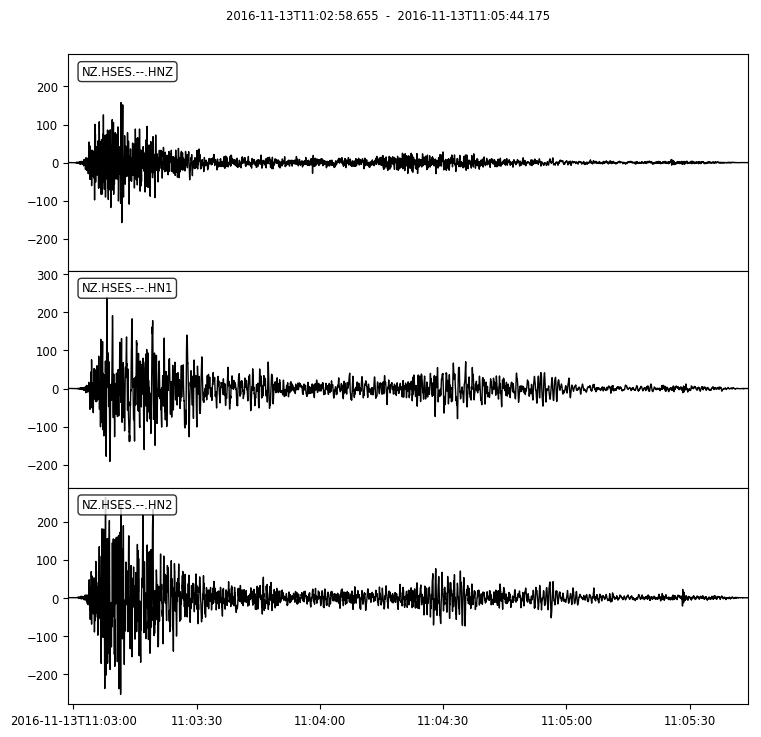

In [16]:
processed_hses.plot()